In [3]:
# !pip install azure-ai-formrecognizer azure-core

In [ ]:

from azure.core.credentials import AzureKeyCredential
from azure.ai.formrecognizer import DocumentAnalysisClient
import os 

AZURE_ENDPOINT = os.getenv("AZURE_ENDPOINT")
AZURE_KEY = os.getenv("AZURE_KEY")

In [2]:
INPUT_IMAGES_DIR = "input_images"
YOLO_OUTPUT_DIR = "yolo_word_detection_dataset"

os.makedirs(YOLO_OUTPUT_DIR, exist_ok=True)

## Prepare dataset for bbox prediction on textual OCR

In [28]:

class AzureWordBBoxExtractor:
    def __init__(self, endpoint: str, key: str):
        self.client = DocumentAnalysisClient(
            endpoint=endpoint,
            credential=AzureKeyCredential(key)
        )
    
    def extract_word_bboxes(self, image_path: str) -> Dict:
        """Extract word-level bounding boxes for YOLO training"""
        
        with open(image_path, "rb") as f:
            poller = self.client.begin_analyze_document("prebuilt-read", document=f)
        result = poller.result()
        
        # Get image dimensions
        with open(image_path, 'rb') as img_file:
            from PIL import Image
            img = Image.open(img_file)
            img_width, img_height = img.size
        
        word_annotations = {
            "image_path": image_path,
            "image_name": Path(image_path).name,
            "image_width": img_width,
            "image_height": img_height,
            "word_bboxes": []
        }
        
        # Extract word bounding boxes
        for page in result.pages:
            for word in (page.words if hasattr(page, 'words') else []):
                if word.polygon and len(word.polygon) >= 4:
                    # Get bounding box from polygon
                    x_coords = [point.x for point in word.polygon]
                    y_coords = [point.y for point in word.polygon]
                    
                    x_min, x_max = min(x_coords), max(x_coords)
                    y_min, y_max = min(y_coords), max(y_coords)
                    
                    # Convert to YOLO format (normalized coordinates)
                    x_center = (x_min + x_max) / 2.0 / img_width
                    y_center = (y_min + y_max) / 2.0 / img_height
                    width = (x_max - x_min) / img_width
                    height = (y_max - y_min) / img_height
                    
                    # Keep all words (no filtering as requested)
                    word_annotations["word_bboxes"].append({
                        "class": 0,  # Single class: "word"
                        "x_center": x_center,
                        "y_center": y_center,
                        "width": width,
                        "height": height,
                        "text": word.content,
                        "confidence": getattr(word, 'confidence', 1.0),
                        "bbox_pixel": [x_min, y_min, x_max, y_max]
                    })
        
        return word_annotations

# Initialize extractor
azure_bbox_extractor = AzureWordBBoxExtractor(AZURE_ENDPOINT, AZURE_KEY)

# Cell 4: Process Images and Extract Word Bounding Boxes
print("Extracting word-level bounding boxes for YOLO training...")

all_annotations = {}
image_files = list(Path(INPUT_IMAGES_DIR).glob("*.jpg")) + \
              list(Path(INPUT_IMAGES_DIR).glob("*.png")) + \
              list(Path(INPUT_IMAGES_DIR).glob("*.jpeg"))

for image_path in tqdm(image_files, desc="Processing images"):
    try:
        # Extract word bounding boxes
        annotations = azure_bbox_extractor.extract_word_bboxes(str(image_path))
        all_annotations[str(image_path)] = annotations
        
        print(f"Processed {image_path.name}: {len(annotations['word_bboxes'])} words")
        
        # Respect API rate limits
        time.sleep(1.0)
        
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

print(f"Total images processed: {len(all_annotations)}")
total_word_boxes = sum(len(ann['word_bboxes']) for ann in all_annotations.values())
print(f"Total word bounding boxes: {total_word_boxes}")



Extracting word-level bounding boxes for YOLO training...


Processing images:   0%|          | 0/18 [00:00<?, ?it/s]

Processed img_9.png: 224 words


Processing images:   6%|▌         | 1/18 [00:04<01:22,  4.85s/it]

Processed img_8.png: 185 words


Processing images:  11%|█         | 2/18 [00:08<01:04,  4.02s/it]

Processed denial.png: 405 words


Processing images:  17%|█▋        | 3/18 [00:11<00:57,  3.86s/it]

Processed img_14.png: 180 words


Processing images:  22%|██▏       | 4/18 [00:16<00:57,  4.11s/it]

Processed img_5.png: 275 words


Processing images:  28%|██▊       | 5/18 [00:20<00:51,  3.95s/it]

Processed img_4.png: 182 words


Processing images:  33%|███▎      | 6/18 [00:23<00:46,  3.85s/it]

Processed img_15.png: 191 words


Processing images:  39%|███▉      | 7/18 [00:27<00:41,  3.74s/it]

Processed img_17.png: 345 words


Processing images:  44%|████▍     | 8/18 [00:30<00:36,  3.67s/it]

Processed img_6.png: 308 words


Processing images:  50%|█████     | 9/18 [00:34<00:32,  3.62s/it]

Processed img_7.png: 454 words


Processing images:  56%|█████▌    | 10/18 [00:37<00:28,  3.60s/it]

Processed img_16.png: 422 words


Processing images:  61%|██████    | 11/18 [00:41<00:25,  3.58s/it]

Processed img_12.png: 213 words


Processing images:  67%|██████▋   | 12/18 [00:44<00:21,  3.54s/it]

Processed img_3.png: 202 words


Processing images:  72%|███████▏  | 13/18 [00:49<00:19,  3.84s/it]

Processed img_2.png: 326 words


Processing images:  78%|███████▊  | 14/18 [00:53<00:16,  4.06s/it]

Processed img_13.png: 128 words


Processing images:  83%|████████▎ | 15/18 [00:57<00:11,  3.86s/it]

Processed img_11.png: 12 words


Processing images:  89%|████████▉ | 16/18 [01:00<00:07,  3.68s/it]

Processed img_1.png: 240 words


Processing images:  94%|█████████▍| 17/18 [01:04<00:03,  3.61s/it]

Processed img_10.png: 267 words


Processing images: 100%|██████████| 18/18 [01:07<00:00,  3.76s/it]

Total images processed: 18
Total word bounding boxes: 4559


### Create dataset for model finetuning (YoloV8)

In [30]:
from sklearn.model_selection import train_test_split
import yaml

class YOLOWordDatasetCreator:
    def __init__(self, dataset_root: str):
        self.dataset_root = Path(dataset_root)
        self.images_dir = self.dataset_root / "images"
        self.labels_dir = self.dataset_root / "labels"
        
        # Create YOLO directory structure
        for split in ['train', 'val', 'test']:
            (self.images_dir / split).mkdir(parents=True, exist_ok=True)
            (self.labels_dir / split).mkdir(parents=True, exist_ok=True)
    
    def create_yolo_annotations(self, image_path: str, annotations: Dict, split: str):
        """Create YOLO format annotation files for word detection"""
        
        image_name = Path(image_path).name
        image_stem = Path(image_path).stem
        
        # Copy image to split directory
        dst_image_path = self.images_dir / split / image_name
        shutil.copy2(image_path, dst_image_path)
        
        # Create YOLO label file
        label_path = self.labels_dir / split / f"{image_stem}.txt"
        
        with open(label_path, 'w') as f:
            for bbox in annotations['word_bboxes']:
                # YOLO format: class x_center y_center width height
                line = f"{bbox['class']} {bbox['x_center']:.6f} {bbox['y_center']:.6f} {bbox['width']:.6f} {bbox['height']:.6f}\n"
                f.write(line)
    
    def split_dataset(self, annotations_dict: Dict, train_ratio: float = 0.7, val_ratio: float = 0.2):
        """Split dataset into train/val/test"""
        
        # Filter images with word annotations
        valid_images = [path for path, ann in annotations_dict.items() 
                       if len(ann['word_bboxes']) > 0]
        
        print(f"Valid images with word annotations: {len(valid_images)}")
        
        # Split data
        train_paths, temp_paths = train_test_split(
            valid_images, test_size=(1 - train_ratio), random_state=42
        )
        val_paths, test_paths = train_test_split(
            temp_paths, test_size=(1 - val_ratio/(1 - train_ratio)), random_state=42
        )
        
        print(f"Dataset split: Train={len(train_paths)}, Val={len(val_paths)}, Test={len(test_paths)}")
        
        # Create annotations for each split
        for paths, split in [(train_paths, 'train'), (val_paths, 'val'), (test_paths, 'test')]:
            for img_path in paths:
                annotations = annotations_dict[img_path]
                self.create_yolo_annotations(img_path, annotations, split)
        
        return len(train_paths), len(val_paths), len(test_paths)
    
    def create_yaml_config(self, num_classes: int = 1):
        """Create YOLO dataset configuration file"""
        config = {
            'path': str(self.dataset_root.absolute()),
            'train': 'images/train',
            'val': 'images/val', 
            'test': 'images/test',
            'nc': num_classes,
            'names': ['word']  # Single class for word detection
        }
        
        yaml_path = self.dataset_root / "dataset.yaml"
        with open(yaml_path, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)
        
        return str(yaml_path)

# Create YOLO dataset
dataset_creator = YOLOWordDatasetCreator(YOLO_OUTPUT_DIR)
train_count, val_count, test_count = dataset_creator.split_dataset(all_annotations)
yaml_config_path = dataset_creator.create_yaml_config()


Valid images with word annotations: 18
Dataset split: Train=12, Val=4, Test=2


### Checking the created data (visualization) 

Visualizing word detection annotations...
Visualizing img_9.png


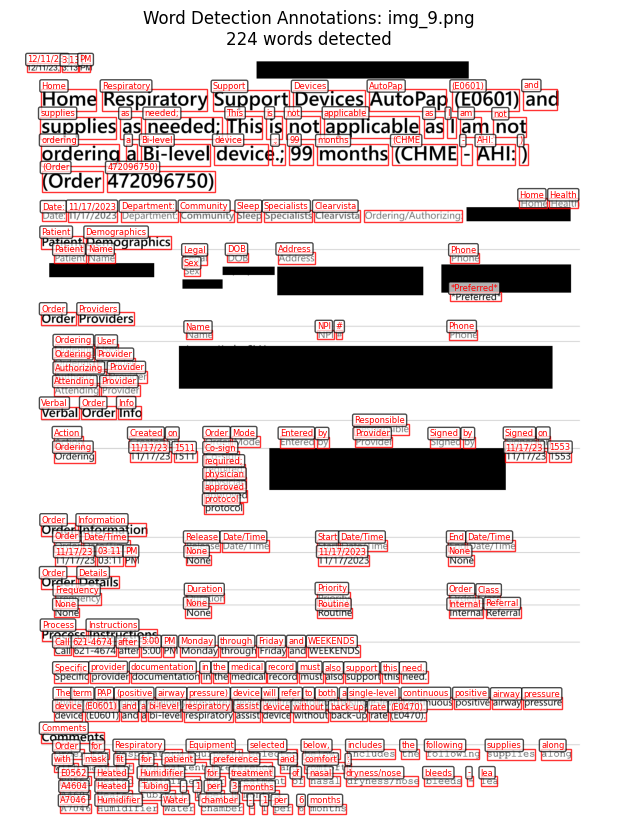

Visualizing img_8.png


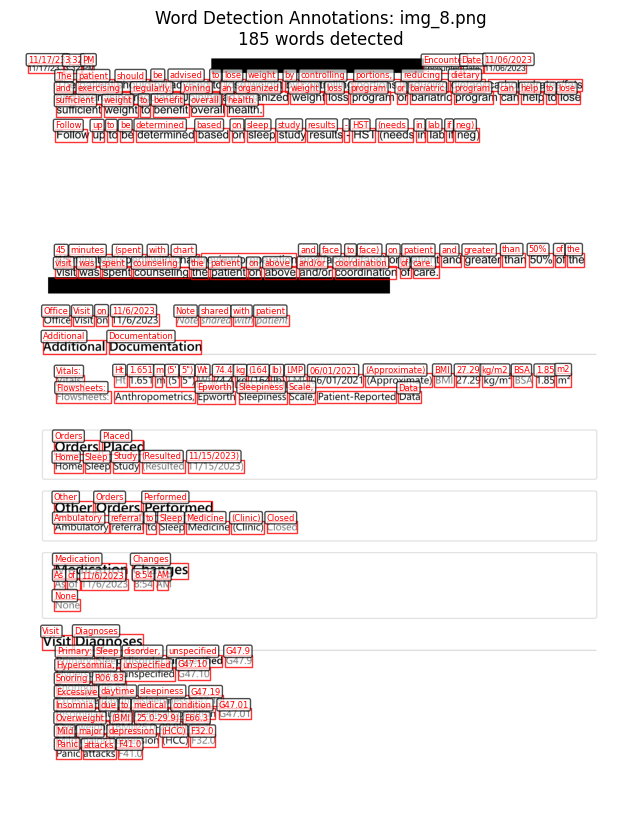

Visualizing denial.png


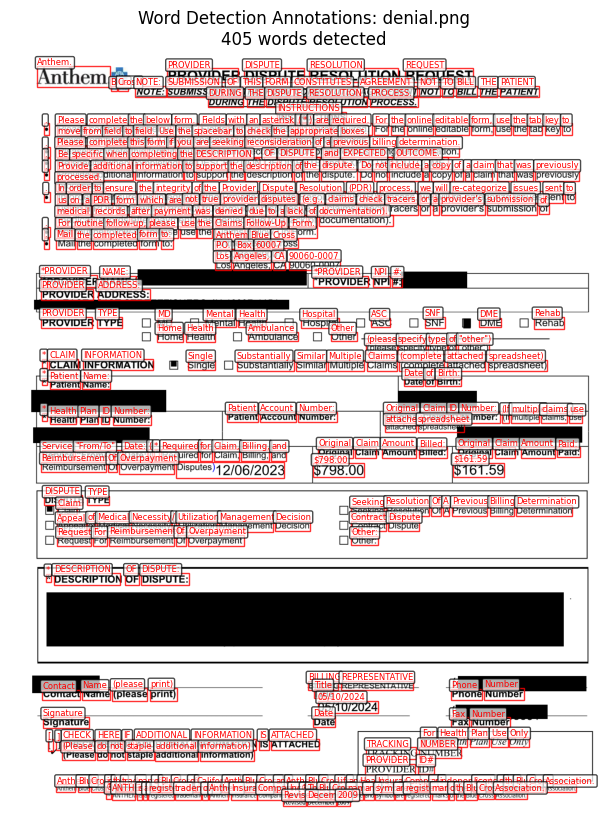

📊 Word Detection Dataset Statistics:
Total images: 18
Total word bounding boxes: 4559
Average words per image: 253.3
Words per image range: 12 - 454
Average bbox area (normalized): 0.000684
Average aspect ratio: 3.15
✅ Dataset info saved to: yolo_word_detection_dataset/word_detection_info.json


In [33]:
def visualize_word_detection(image_path: str, annotations: Dict, save_path: str = None):
    """Visualize word-level bounding boxes on image"""
    
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(img_rgb)
    
    # Draw word bounding boxes
    for bbox in annotations['word_bboxes']:
        # Convert normalized coordinates back to pixel coordinates
        x_center = bbox['x_center'] * w
        y_center = bbox['y_center'] * h
        width = bbox['width'] * w
        height = bbox['height'] * h
        
        x1 = x_center - width/2
        y1 = y_center - height/2
        
        # Draw bounding box
        rect = patches.Rectangle((x1, y1), width, height, 
                               linewidth=1, edgecolor='red', facecolor='none', alpha=0.8)
        ax.add_patch(rect)
        
        # Add word text
        if len(bbox['text']) <= 15:  # Only show short words to avoid clutter
            ax.text(x1, y1-2, bbox['text'], color='red', fontsize=6,
                   bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.7))
    
    ax.set_title(f"Word Detection Annotations: {annotations['image_name']}\n{len(annotations['word_bboxes'])} words detected")
    ax.axis('off')
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Visualize sample annotations
print("Visualizing word detection annotations...")
sample_images = list(all_annotations.keys())[:3]

for i, img_path in enumerate(sample_images):
    if all_annotations[img_path]['word_bboxes']:
        print(f"Visualizing {Path(img_path).name}")
        visualize_word_detection(img_path, all_annotations[img_path])

# Cell 7: Dataset Statistics
def analyze_word_detection_dataset(annotations_dict: Dict):
    """Analyze the word detection dataset"""
    
    total_images = len(annotations_dict)
    total_words = sum(len(ann['word_bboxes']) for ann in annotations_dict.values())
    
    # Word count per image
    words_per_image = [len(ann['word_bboxes']) for ann in annotations_dict.values()]
    
    # Bounding box size analysis
    bbox_areas = []
    bbox_aspect_ratios = []
    
    for annotations in annotations_dict.values():
        for bbox in annotations['word_bboxes']:
            area = bbox['width'] * bbox['height']
            aspect_ratio = bbox['width'] / bbox['height'] if bbox['height'] > 0 else 0
            bbox_areas.append(area)
            bbox_aspect_ratios.append(aspect_ratio)
    
    print("Word Detection Dataset Statistics:")
    print(f"Total images: {total_images}")
    print(f"Total word bounding boxes: {total_words}")
    print(f"Average words per image: {np.mean(words_per_image):.1f}")
    print(f"Words per image range: {min(words_per_image)} - {max(words_per_image)}")
    print(f"Average bbox area (normalized): {np.mean(bbox_areas):.6f}")
    print(f"Average aspect ratio: {np.mean(bbox_aspect_ratios):.2f}")

analyze_word_detection_dataset(all_annotations)

dataset_info = {
    "dataset_type": "word_detection",
    "total_images": len(all_annotations),
    "total_word_boxes": sum(len(ann['word_bboxes']) for ann in all_annotations.values()),
    "train_images": train_count,
    "val_images": val_count, 
    "test_images": test_count,
    "num_classes": 1,
    "class_names": ["word"],
    "yaml_config": yaml_config_path,
    "annotations": all_annotations
}

# Save dataset info
info_path = os.path.join(YOLO_OUTPUT_DIR, "word_detection_info.json")
with open(info_path, 'w') as f:
    json.dump(dataset_info, f, indent=2)

print(f"Dataset info saved to: {info_path}")


In [34]:
# !pip install opencv-python pillow matplotlib pandas numpy tqdm requests ultralytics scikit-learn
